<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#NumPy-implementation-of-a-simple-RNN" data-toc-modified-id="NumPy-implementation-of-a-simple-RNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>NumPy implementation of a simple RNN</a></span></li><li><span><a href="#A-recurrent-layer-in-Keras" data-toc-modified-id="A-recurrent-layer-in-Keras-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A recurrent layer in Keras</a></span><ul class="toc-item"><li><span><a href="#IMDB-dataa" data-toc-modified-id="IMDB-dataa-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>IMDB dataa</a></span></li><li><span><a href="#Training-the-model-with-Embedding-and-SimpleRNN-layers" data-toc-modified-id="Training-the-model-with-Embedding-and-SimpleRNN-layers-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Training the model with <code>Embedding</code> and <code>SimpleRNN</code> layers</a></span></li></ul></li><li><span><a href="#A-concrete-LSTM-example-in-Keras" data-toc-modified-id="A-concrete-LSTM-example-in-Keras-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A concrete LSTM example in Keras</a></span></li></ul></div>

A major characteristic of all NN seen so far, is that they have no memory. Each input shown to them is processed independently, with no state kept in between inputs. Such NN are called **feedforward networks**. 

A **recurrent neural network (RNN)** processes sequences by iterating through the sequence elements and maintaining a **state** containing information relative to what it has seen so far. In effect, RNN is a type of NN that has an internal loop. The state of the RNN is reset between processing two different, independent sequences (such as two movie reviews), so you still consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step, rather, the network internally loops over sequence elements. 

# NumPy implementation of a simple RNN

This RNN takes as input a sequence of vectors, which you will encodeas a 2D tensor of size ```(timesteps, input_features)```. It loops over timesteps, and at each timestep, it considers its current state at *t* and the input at *t* (of shape ```(input_features, )``` and combines them to obtain the output at *t*.

In [1]:
import numpy as np

In [2]:
timesteps = 100 # Number of timesteps in the input sequence
input_features = 32 # Dimensionality of the input feature space
output_features = 64 # Dimensionality of the output feature space

In [3]:
inputs = np.random.random((timesteps, input_features)) # Random noise for the sake of the example

In [4]:
state_t = np.zeros((output_features, )) # Initial state: an all-zero vector

In [5]:
W = np.random.random((output_features, input_features))

In [6]:
U = np.random.random((output_features, output_features))

In [7]:
b = np.random.random((output_features, ))

In [8]:
W.shape

(64, 32)

In [9]:
U.shape

(64, 64)

In [10]:
b.shape

(64,)

In [11]:
successive_outputs = []

In [12]:
for input_t in inputs: # input_t is a vector of shape (input_features)
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b) # Combine the input with the current state to obtain the current output
    successive_outputs.append(output_t)
    state_t = output_t # Update the state of the network for the next timestep
    

In [13]:
# The final output is a 2D tensor of shape (timesteps, output_features)
final_output_sequence = np.concatenate(successive_outputs, axis=0)

In [14]:
final_output_sequence.shape

(6400,)

In [15]:
len(successive_outputs)

100

In [16]:
successive_outputs[0].shape

(64,)

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/Figures/06fig10_alt.jpg)

In this example, the final output is a 2D tensor of shape (timesteps, output_features), where each timestep is the output of the loop at time t. Each timestep t in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, you don’t need this full sequence of outputs; you just need the last output (output_t at the end of the loop), because it already contains information about the entire sequence. 

# A recurrent layer in Keras

Like all recurrent layers in Keras, SimpleRNN can be run in two different modes: it can return either the full sequences of successive outputs for each timestep (a 3D tensor of shape ```(batch_size, timesteps, output_features)```) or only the last output for each input sequence (a 2D tensor of shape ```(batch_size, output_features)```). These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep: 

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

Using TensorFlow backend.


In [18]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


The following example returns the full state sequence

In [19]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return full sequence of outputs: 

In [20]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's use such a model on the IMDB movie-review classification problem. First, prepocess the data.

## IMDB dataa

In [21]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [22]:
max_features = 10000
maxlen = 500
batch_size = 32

In [23]:
print("Loading data...")
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

Loading data...


In [24]:
print(len(input_train), 'train sequences')

25000 train sequences


In [25]:
print(len(input_test), 'test sequences')

25000 test sequences


In [26]:
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

Pad sequences (samples x time)


In [27]:
print('input_train shape: ', input_train.shape)
print('input_test shape: ', input_test.shape)

input_train shape:  (25000, 500)
input_test shape:  (25000, 500)


## Training the model with ```Embedding``` and ```SimpleRNN``` layers

In [28]:
from keras.layers import Dense

In [29]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [32]:
%%time

history = model.fit(input_train, y_train, epochs=10,
                    batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 35s 2ms/step - loss: 0.5596 - acc: 0.7021 - val_loss: 0.4049 - val_acc: 0.8312
Epoch 2/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.3514 - acc: 0.8564 - val_loss: 0.6336 - val_acc: 0.7392
Epoch 3/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2878 - acc: 0.8854 - val_loss: 0.4002 - val_acc: 0.8314
Epoch 4/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.2320 - acc: 0.9102 - val_loss: 0.4501 - val_acc: 0.7908
Epoch 5/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.1833 - acc: 0.9331 - val_loss: 0.3903 - val_acc: 0.8354
Epoch 6/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.1375 - acc: 0.9489 - val_loss: 0.4155 - val_acc: 0.8224
Epoch 7/10
20000/20000 [==============================] - 25s 1ms/step - loss: 0.1015 - acc: 0.9651 - val_loss: 0.4380 - val_acc:

In [33]:
import matplotlib.pyplot as plt 
%matplotlib inline


In [38]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    epochs = range(1, len(acc_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.plot(epochs, acc_values, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'r', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Validation')
    plt.legend()
    plt.show()

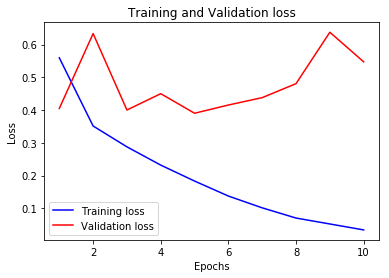

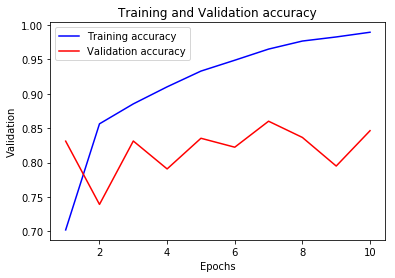

In [39]:
plot_history(history)

# A concrete LSTM example in Keras

In [40]:
from keras.layers import LSTM

In [42]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

In [43]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [44]:
%%time
history = model.fit(input_train, y_train, epochs=10,
                    batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 108s 5ms/step - loss: 0.5483 - acc: 0.7346 - val_loss: 0.4207 - val_acc: 0.8166
Epoch 2/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.3116 - acc: 0.8737 - val_loss: 0.7801 - val_acc: 0.7012
Epoch 3/10
20000/20000 [==============================] - 110s 6ms/step - loss: 0.2495 - acc: 0.9030 - val_loss: 0.2949 - val_acc: 0.8772
Epoch 4/10
20000/20000 [==============================] - 110s 6ms/step - loss: 0.2045 - acc: 0.9243 - val_loss: 0.3539 - val_acc: 0.8684
Epoch 5/10
20000/20000 [==============================] - 110s 5ms/step - loss: 0.1868 - acc: 0.9300 - val_loss: 0.3548 - val_acc: 0.8626
Epoch 6/10
20000/20000 [==============================] - 116s 6ms/step - loss: 0.1640 - acc: 0.9392 - val_loss: 0.3458 - val_acc: 0.8684
Epoch 7/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.1505 - acc: 0.9461 - val_loss: 0.3331 - v

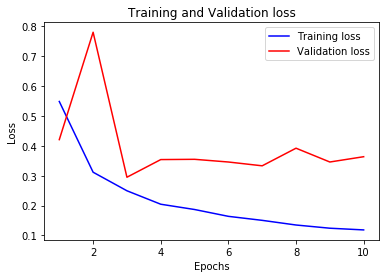

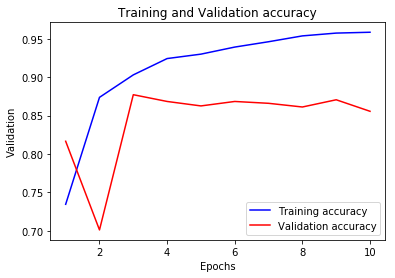

In [45]:
plot_history(history)